In [3]:
# 資料清理
# 安裝套件
!pip install nltk pandas

# 載入套件
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords

# 下載 NLTK 停用詞
nltk.download('stopwords')

# 上傳 CSV 檔案
from google.colab import files
uploaded = files.upload()

# 讀取檔案
df = pd.read_csv("sentiment_data.csv")

# 定義前處理函數
def preprocess_text(text):
    text = str(text).lower()  # 全轉小寫
    text = re.sub(r"http\S+", "", text)  # 移除網址
    text = text.translate(str.maketrans("", "", string.punctuation))  # 去除標點
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words("english")]  # 去除停用詞
    return " ".join(tokens)

# 執行前處理
df["cleaned_comment"] = df["comment"].apply(preprocess_text)

# 預覽結果
df[["comment", "cleaned_comment"]].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,comment,cleaned_comment
0,lets forget apple pay required brand new iphon...,lets forget apple pay required brand new iphon...
1,nz retailers don? even contactless credit car...,nz retailers don even contactless credit card...
2,forever acknowledge channel help lessons ideas...,forever acknowledge channel help lessons ideas...
3,whenever go place doesn? take apple pay doesn...,whenever go place doesn take apple pay doesn...
4,apple pay convenient secure easy use used kore...,apple pay convenient secure easy use used kore...


In [4]:
# 儲存清理後的資料
df.to_csv("cleaned_sentiment_data.csv", index=False)

# 下載檔案到本地端
files.download("cleaned_sentiment_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# 安裝必要套件（若尚未安裝）
!pip install scikit-learn pandas matplotlib --quiet

# 匯入套件
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

<ipython-input-7-429507b11c2d>:10: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv("cleaned_sentiment140.csv", encoding="ISO-8859-1", header=None)
<ipython-input-7-429507b11c2d>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_df['target'] = full_df['target'].replace({4: 1})


Validation Accuracy: 0.7520


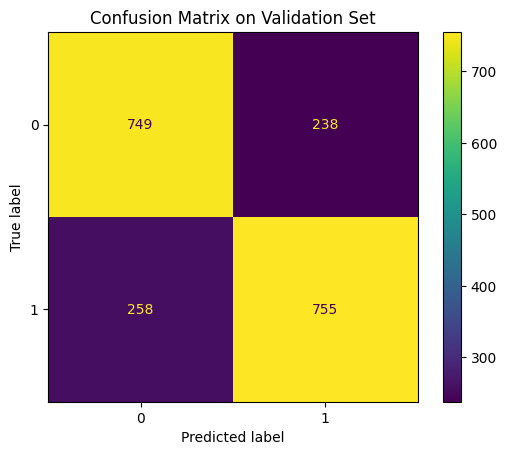

In [7]:
# ========== 第 1 部分：訓練模型 ==========

# 自訂清理文字的函式
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # 移除網址
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # 移除標點、符號、數字
    return text.lower().strip()

# 讀取 sentiment140 原始資料（包含 0 與 4 標籤）
full_df = pd.read_csv("cleaned_sentiment140.csv", encoding="ISO-8859-1", header=None)
full_df = full_df[[0, 5]]
full_df.columns = ['target', 'text']

# 篩選 0 與 4 類別，轉為 0=negative, 1=positive
full_df = full_df[full_df['target'].isin([0, 4])]
full_df['target'] = full_df['target'].replace({4: 1})

# 各取樣 5000 筆正面/負面
df_pos = full_df[full_df['target'] == 1].sample(5000, random_state=42)
df_neg = full_df[full_df['target'] == 0].sample(5000, random_state=42)
train_df = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# 清理文字
train_df['text'] = train_df['text'].apply(clean_text)

# 拆成 X 和 y
X = train_df['text']
y = train_df['target']

# 拆成訓練/驗證集
X_train_text, X_val_text, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 向量化：使用 TF-IDF + n-gram (1,2)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train_text)
X_val_vec = vectorizer.transform(X_val_text)

# 訓練模型
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# 驗證集預測 + 評估
y_pred = model.predict(X_val_vec)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

# 顯示混淆矩陣
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot()
plt.title("Confusion Matrix on Validation Set")
plt.show()

In [8]:
# ========== 第 2 部分：載入留言並預測 ========== variable part

# 載入留言資料
comments_df = pd.read_csv("cleaned_sentiment_data.csv")

# 過濾掉空白留言（使用 cleaned_comment 欄位）
comments_df = comments_df[comments_df['cleaned_comment'].str.strip().astype(bool)]

# 取出 cleaned_comment 欄位作為輸入文本
X_comments_text = comments_df['cleaned_comment']

# 使用與訓練時相同的 vectorizer 轉換
X_comments_text = X_comments_text.fillna("")
X_comments_vec = vectorizer.transform(X_comments_text)

# 預測
preds = model.predict(X_comments_vec)

# 將 0/1 轉為文字標籤
pred_labels = np.where(preds == 1, 'positive', 'negative')

# 儲存結果
results_df = pd.DataFrame({
    'comment': X_comments_text,
    'prediction': pred_labels
})

results_df.to_csv("predicted_comments.csv", index=False)

# 顯示前幾筆
print(results_df.head())


                                             comment prediction
0  lets forget apple pay required brand new iphon...   positive
1  nz retailers don even contactless credit card...   positive
2  forever acknowledge channel help lessons ideas...   positive
3  whenever go place doesn take apple pay doesn...   negative
4  apple pay convenient secure easy use used kore...   negative


In [9]:
# test part
test_sentences = [
    "This is a disaster. Completely foolish move.",
    "let’s see really helps economy",
    "I want to suicide"
]

X_test = vectorizer.transform(test_sentences)
preds = model.predict(X_test)
print(preds)

[0 1 0]


In [10]:
# 統計正面 / 負面數量
from collections import Counter

counter = Counter(pred_labels)
positive_count = counter['positive']
negative_count = counter['negative']
total = positive_count + negative_count

print(f"Positive: {positive_count} ({positive_count / total:.2%})")
print(f"Negative: {negative_count} ({negative_count / total:.2%})")

# 加上一段文字結論
if positive_count>negative_count:
    print("整體情緒偏正面。")
elif negative_count>positive_count:
    print("整體情緒偏負面。")
else:
    print("整體情緒平均。")


Positive: 148103 (61.42%)
Negative: 93042 (38.58%)
整體情緒偏正面。


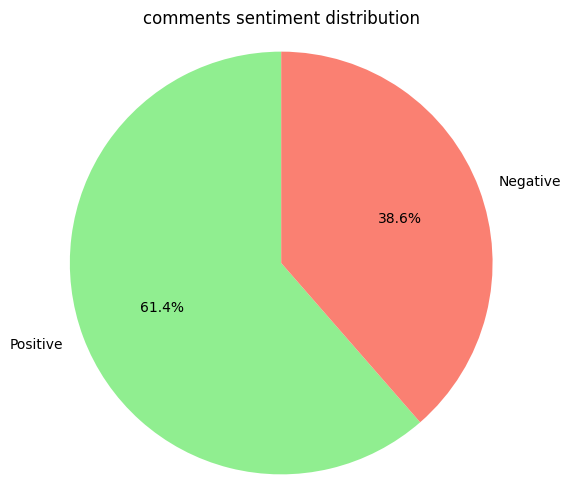

In [11]:
# 視覺化正面/負面情緒分佈
import matplotlib.pyplot as plt

labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("comments sentiment distribution")
plt.axis('equal')  # 讓圓形不會被拉長
plt.show()




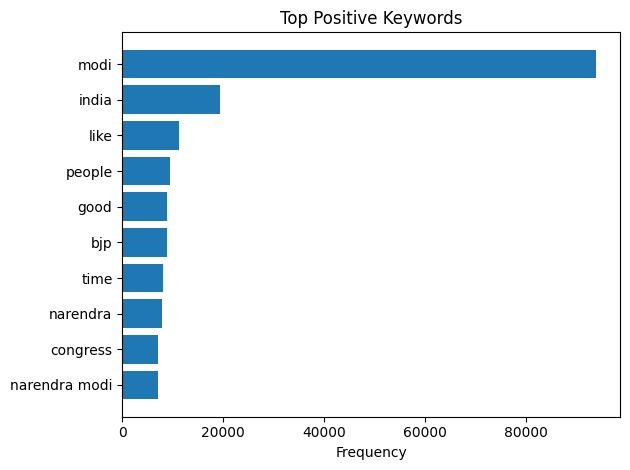

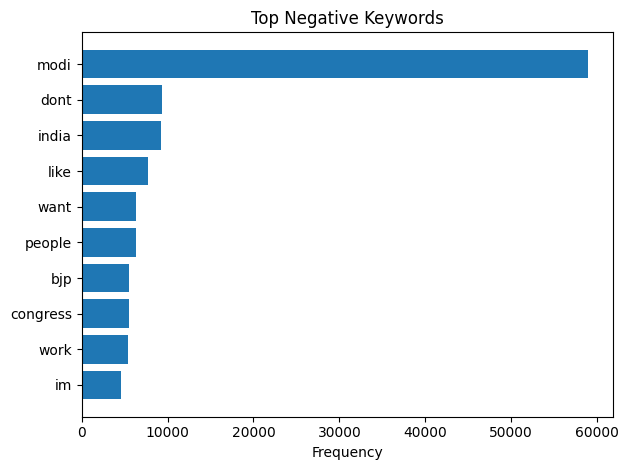

In [19]:
# ---------- 依賴套件 ----------
import pandas as pd, re, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("predicted_comments.csv")
TOP_K     = 10

# ---------- 簡易清理 ----------
def clean(text):
    text = str(text) if not isinstance(text, str) else text
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower()

df["clean"] = df["comment"].map(clean)

# ---------- 取關鍵詞 ----------
def top_words(series, k):
    cv   = CountVectorizer(stop_words="english", ngram_range=(1,2), max_features=10000)
    mat  = cv.fit_transform(series)
    freq = mat.sum(axis=0).A1
    vocab= cv.get_feature_names_out()
    top  = sorted(zip(vocab, freq), key=lambda x: x[1], reverse=True)[:k]
    words, counts = zip(*top) if top else ([],[])
    return list(words)[::-1], list(counts)[::-1]    # 反轉讓 barh 從大到小

pos_w, pos_c = top_words(df.loc[df.prediction=="positive","clean"], TOP_K)
neg_w, neg_c = top_words(df.loc[df.prediction=="negative","clean"], TOP_K)

# ---------- 畫圖 ----------
plt.figure()
plt.barh(pos_w, pos_c)
plt.title("Top Positive Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(neg_w, neg_c)
plt.title("Top Negative Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


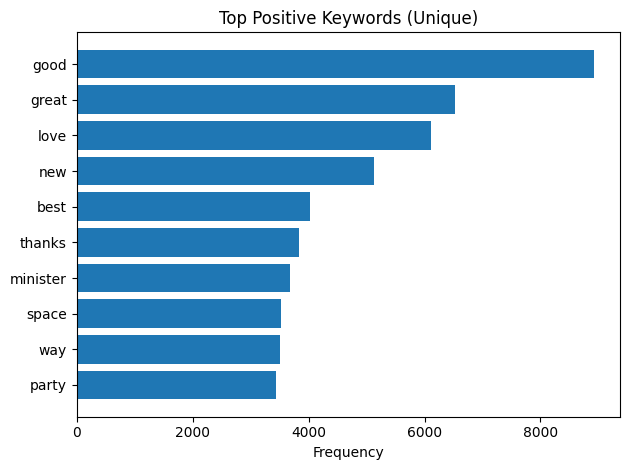

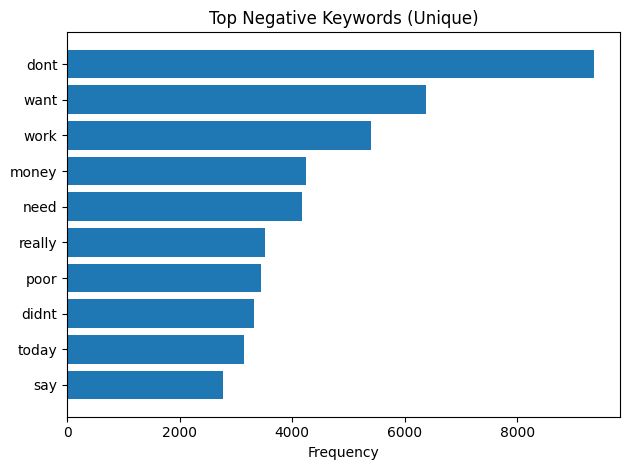

此貼文共有 241145 則留言，positive 類別 148103 則（占 61.4%）。主要關鍵詞為 good, great, love, new, best，顯示留言者多聚焦上述議題，因此整體情緒偏正面。


In [18]:
# ---------- 新增功能：排除正負面共通關鍵詞 ----------

# 建立完整詞頻字典
pos_all_w, pos_all_c = top_words(df.loc[df.prediction=="positive","clean"], TOP_K*5)
neg_all_w, neg_all_c = top_words(df.loc[df.prediction=="negative","clean"], TOP_K*5)

# 轉成 dict 方便查頻率
pos_dict = dict(zip(pos_all_w, pos_all_c))
neg_dict = dict(zip(neg_all_w, neg_all_c))

# 找出正面獨有、負面獨有的詞
unique_pos = [(w, c) for w, c in pos_dict.items() if w not in neg_dict]
unique_neg = [(w, c) for w, c in neg_dict.items() if w not in pos_dict]

# 挑前 TOP_K
unique_pos = sorted(unique_pos, key=lambda x: x[1], reverse=True)[:TOP_K]
unique_neg = sorted(unique_neg, key=lambda x: x[1], reverse=True)[:TOP_K]

# 拆開詞與頻率
pos_w_unique, pos_c_unique = zip(*unique_pos) if unique_pos else ([], [])
neg_w_unique, neg_c_unique = zip(*unique_neg) if unique_neg else ([], [])

# ---------- 畫圖（移除共通詞後的） ----------
plt.figure()
plt.barh(pos_w_unique[::-1], pos_c_unique[::-1])
plt.title("Top Positive Keywords (Unique)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(neg_w_unique[::-1], neg_c_unique[::-1])
plt.title("Top Negative Keywords (Unique)")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# ---------- 生成敘述用的五個關鍵詞 ----------
if major == "positive":
    target_words = unique_pos
else:
    target_words = unique_neg

# 取前五個詞
words = [w for w, _ in target_words[:5]]
if len(words) < 5:
    words += ["..."] * (5 - len(words))

# ---------- 組合句子 ----------
explanation = (
    f"此貼文共有 {cnt.sum()} 則留言，{major} 類別 {major_n} 則（占 {ratio:.1%}）。"
    f"主要關鍵詞為 {', '.join(words)}，"
    f"顯示留言者多聚焦上述議題，因此整體情緒偏{'正面' if major == 'positive' else '負面'}。"
)

print(explanation)



In [20]:
# pip install python-pptx pandas matplotlib scikit-learn --quiet
!pip install python-pptx

import pandas as pd, matplotlib.pyplot as plt, re, datetime as dt, warnings
from sklearn.feature_extraction.text import CountVectorizer
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

CSV_PATH = "predicted_comments.csv"
TOP_K    = 10                         # 關鍵詞排名數

# ---------- 1. 讀檔 + 基本統計 ----------
df   = pd.read_csv(CSV_PATH)
cnt  = df["prediction"].value_counts()
pos, neg = cnt.get("positive", 0), cnt.get("negative", 0)
total    = pos + neg

# ---------- 2. 圓餅 & 整體長條 ----------
plt.figure()
plt.pie([pos, neg], labels=["Positive", "Negative"], autopct='%1.1f%%', startangle=90)
plt.axis('equal'); plt.tight_layout(); plt.savefig("pie.png"); plt.close()

plt.figure()
plt.bar(["Positive", "Negative"], [pos, neg])
plt.ylabel("Count"); plt.tight_layout(); plt.savefig("bar.png"); plt.close()

# ---------- 3. 抓各類別 Top-K 關鍵詞 ----------
def clean(t): return re.sub(r"[^a-zA-Z\s]", " ", re.sub(r"http\S+", " ", str(t))).lower()
df["clean"] = df["comment"].map(clean)

def top_kw(series):
    cv = CountVectorizer(stop_words="english", ngram_range=(1,2), max_features=10000)
    mat = cv.fit_transform(series)
    freqs = mat.sum(axis=0).A1
    vocab = cv.get_feature_names_out()
    w, c  = zip(*sorted(zip(vocab, freqs), key=lambda x:x[1], reverse=True)[:TOP_K])
    return list(w)[::-1], list(c)[::-1]          # 反轉給 barh

p_w, p_c = top_kw(df.loc[df.prediction=="positive","clean"])
n_w, n_c = top_kw(df.loc[df.prediction=="negative","clean"])

for lbl, w_list, c_list in [("pos", p_w, p_c), ("neg", n_w, n_c)]:
    plt.figure()
    plt.barh(w_list, c_list)
    plt.xlabel("Frequency")
    plt.title("Top Positive Keywords" if lbl=="pos" else "Top Negative Keywords")
    plt.tight_layout()
    plt.savefig(f"{lbl}.png")
    plt.close()

# ---------- 4. 結論 ----------
ratio_pct = f"{major_n / cnt.sum() * 100:.1f}%"

explanation = (
    f"此貼文共有 {cnt.sum()} 則留言，{major} 類別 {major_n} 則（占 {ratio_pct}）。"
    f"主要關鍵詞為 {', '.join(words)}，"
    f"顯示留言者多聚焦上述議題，因此整體情緒偏{'正面' if major=='positive' else '負面'}。"
)

conclusion = f"結論：{explanation}"

# ---------- 5. 產生 PPT ----------

prs = Presentation()
prs.slides.add_slide(prs.slide_layouts[0])
prs.slides[0].shapes.title.text = "Social Post Sentiment Analysis"
prs.slides[0].placeholders[1].text = f"Generated: {dt.datetime.now():%Y-%m-%d %H:%M}"

for title, img in [("Sentiment Pie Chart","pie.png"),
                   ("Sentiment Bar Chart","bar.png"),
                   ("Top Positive Keywords","pos.png"),
                   ("Top Negative Keywords","neg.png")]:
    s = prs.slides.add_slide(prs.slide_layouts[5])
    s.shapes.title.text = title
    s.shapes.add_picture(img, Inches(1), Inches(1.3), width=Inches(8))

s = prs.slides.add_slide(prs.slide_layouts[1])
s.shapes.title.text = "Conclusion"
p = s.shapes.placeholders[1].text_frame.paragraphs[0]
p.text = conclusion; p.font.size = Pt(24); p.alignment = PP_ALIGN.LEFT

prs.save("sentiment_report.pptx")
print("✅ PPT generated: sentiment_report.pptx")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 14.0 MB/s eta 0:00:00
✅ PPT generated: sentiment_report.pptx


In [ ]:
#---------清理函示-----------
def clean(t):
    t = re.sub(r"http\S+", "", t) #移除網址
    t = re.sub(r"[^a-zA-Z\s]", "", t) #只留字母
    return t.lower().strip()
#----------判斷句子情緒正負面函示---------
def predict_sentiment(text):
    cleaned_text=clean(text) #清理
    vec=vectorizer.transform([text]) #向量化
    predict=model.predict(vec)[0] #帶入模型
    sentiment="positive" if predict == 1 else "negative"
    prob=model.predict_proba(vec)
    prob_positive=prob[0,1]
    prob_negative=prob[0,0]

    #--------抓關鍵詞--------
    feature_names=vectorizer.get_feature_names_out()
    coef=model.coef_[0]
    text_w=set(cleaned_text.split())
    w_contribute=[(word,coef[i]) for i, word in enumerate(feature_names) if word in text_w]
    w_contribute.sort(key=lambda x: abs(x[1]), reverse=True)

    #---------輸出結果並分析----------
    explanation=(
        f"Sentiment: {sentiment.capitalize()}\n"
        f"Probability(pos): {prob_positive:.2f} "
        f"Probability(neg): {prob_negative:.2f}\n"
        f"Contributing words:"
    )
    for word,coef in w_contribute[:5]:
            effect="Positive" if coef>0 else "Negative"
            explanation+=f" >{word}:{effect}({coef:.2f}) "
    if not w_contribute:
            explanation+="No contributin word found.\n"

    return explanation

#測試
test=[
    "Exam tomorrow and I’m totally unprepared 😫",
    "Earthquake shook the house, so scared",
    "You dirty bastard stole my kill",
    "lol",
    "afsfwajnk"
]
for comment in test:
    print(f"Comment:{comment}\n"+predict_sentiment(comment)+"\n")


Comment:Exam tomorrow and I’m totally unprepared 😫
Sentiment: Negative
Probability(pos): 0.35 Probability(neg): 0.65
Contributing words: >tomorrow:Negative(-1.32)  >im:Negative(-1.18)  >and:Positive(0.64)  >exam:Negative(-0.62)  >totally:Negative(-0.12) 

Comment:Earthquake shook the house, so scared
Sentiment: Negative
Probability(pos): 0.28 Probability(neg): 0.72
Contributing words: >scared:Negative(-0.98)  >house:Negative(-0.48)  >so:Negative(-0.45)  >the:Positive(0.15) 

Comment:You dirty bastard stole my kill
Sentiment: Negative
Probability(pos): 0.42 Probability(neg): 0.58
Contributing words: >my:Negative(-2.35)  >you:Positive(2.13)  >stole:Negative(-0.41)  >kill:Negative(-0.32)  >bastard:Negative(-0.12) 

Comment:lol
Sentiment: Positive
Probability(pos): 0.90 Probability(neg): 0.10
Contributing words: >lol:Positive(2.05) 

Comment:afsfwajnk
Sentiment: Positive
Probability(pos): 0.54 Probability(neg): 0.46
Contributing words:No contributin word found.




In [ ]:
#---------CLI------------
while True:
    text=input("please enter your comment(or enter 0 to exit):")
    text=text.strip()
    if text.lower()=="0":
        break
    print(f"Comment:{text}\n"+predict_sentiment(text)+"\n")

Comment:I hate you
Sentiment: Negative
Probability(pos): 0.41 Probability(neg): 0.59
Contributing words: >hate:Negative(-2.33)  >you:Positive(2.13) 

